<a href="https://colab.research.google.com/github/skarlekar/ml-exercises/blob/master/collison_avoidance_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Collision Avoidance - Training the Model**

# Importing packages

Let's start by importing required packages:

* os — to read files and directory structure
* numpy — for some matrix math outside of TensorFlow
* matplotlib.pyplot — to plot the graph and display images in our training and validation data
* tensorflow.keras.preprocessing.image - ImageDataGenerator to preprocess images and generate batches of tensor image data with real-time data augmentation

In [0]:

from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#Cleanup
Initial clean-up in case the notebook is run several times

In [0]:
!rm -r /content/free_blocked

# Make Directory function
Add a utility function to create directories given the parent directory and directory name

In [0]:
import os
def make_dir(parent_dir, dir):
  new_dir = os.path.join(parent_dir, dir)
  try:
    os.mkdir(new_dir)
  except FileExistsError:
    print('Directory {} were not created because they already exist'.format(new_dir))
  finally:
    return new_dir

# Train & Validation Data Generation
Given the URL for the dataset, the original_directory inside the zip file, target directory and validation split percent, this function downloads the dataset, splits it into train and validation dataset and creates the necessary directories

In [0]:
import tensorflow.keras.utils as tfutils
import os
import shutil

def split_two_cat_dataset_into_train_validation(url, original_dir_inside_zip, base_dir, validation_split_pct ):
  zip_dir = tfutils.get_file('two_cat_dataset.zip', origin=_URL, extract=True)
  make_dir('/', base_dir)
  train_dir = make_dir(base_dir, 'train')
  validation_dir = make_dir(base_dir, 'validation')
  train_free_dir = make_dir(train_dir, 'free')
  train_blocked_dir = make_dir(train_dir, 'blocked')
  validation_free_dir = make_dir(validation_dir, 'free')
  validation_blocked_dir = make_dir(validation_dir, 'blocked')
  datasets_dir = os.path.dirname(zip_dir)
  dataset_dir = os.path.join(datasets_dir, original_dir_inside_zip)
  num_training_files = 0
  num_validation_files = 0
  for subdir, dirs, files in os.walk(dataset_dir):
    category_name = os.path.basename(subdir)
    if category_name == os.path.basename(dataset_dir):
      continue
    file_name = os.path.join(dataset_dir, category_name)
    if not category_name.startswith('.'):
      print('Now starting with category: {}'.format(category_name))
      training_data_category_dir = train_dir + '/' + category_name
      validation_data_category_dir = validation_dir + '/' + category_name

      if not os.path.exists(training_data_category_dir):
        os.mkdir(training_data_category_dir)

      if not os.path.exists(validation_data_category_dir):
        os.mkdir(validation_data_category_dir)
      print('---------------------------------------------------------------')
      print('No. of files in category: {}, is {}'.format(category_name, len(files) ))
      validation_pct = (len(files) * validation_split_pct)
      count_valid_files = 0
      print('No. of validation files for category {} is {}'.format(category_name,validation_pct ))
      print('training_data_category_dir: {}'.format(training_data_category_dir))
      print('validation_data_category_dir: {}'.format(validation_data_category_dir))
      for file in files:
        input_file = os.path.join(subdir, file)
        #if np.random.rand(1) < validation_split_pct:
        if count_valid_files < validation_pct:
          shutil.copy(input_file, validation_dir + '/' + category_name + '/' + file)
          num_validation_files += 1
          count_valid_files += 1
        else:
          shutil.copy(input_file, train_dir + '/' + category_name + '/' + file)
          num_training_files += 1
  return train_dir, validation_dir, train_free_dir, train_blocked_dir, validation_free_dir, validation_blocked_dir

# Data Loading
Begin by downloading the dataset using the utility function created above.

In [8]:
_URL='file:///content/drive/My Drive/uploads/dataset.zip'
train_dir, validation_dir, train_free_dir, train_blocked_dir, validation_free_dir, validation_blocked_dir = split_two_cat_dataset_into_train_validation(_URL, 'dataset', '/content/free_blocked', 0.2)

Now starting with category: blocked
---------------------------------------------------------------
No. of files in category: blocked, is 391
No. of validation files for category blocked is 78.2
training_data_category_dir: /content/free_blocked/train/blocked
validation_data_category_dir: /content/free_blocked/validation/blocked
Now starting with category: free
---------------------------------------------------------------
No. of files in category: free, is 308
No. of validation files for category free is 61.6
training_data_category_dir: /content/free_blocked/train/free
validation_data_category_dir: /content/free_blocked/validation/free


# Understanding our data
Let's look at how many free and blocked images we have in our training and validation directory

In [0]:
num_free_tr = len(os.listdir(train_free_dir))
num_blocked_tr = len(os.listdir(train_blocked_dir))

num_free_val = len(os.listdir(validation_free_dir))
num_blocked_val = len(os.listdir(validation_blocked_dir))

total_train = num_free_tr + num_blocked_tr
total_val = num_free_val + num_blocked_val

total_free = num_free_tr + num_free_val
total_blocked = num_blocked_tr + num_blocked_val

num_classes = 2 # We have two categories, viz., 'free' and 'blocked'
num_training_examples = total_train
num_validation_examples = total_val

In [10]:
print('total free images:', total_free)
print('total blocked images:', total_blocked)
print("--")

print('total training free images:', num_free_tr)
print('total training blocked images:', num_blocked_tr)

print('total validation free images:', num_free_val)
print('total validation blocked images:', num_blocked_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total free images: 308
total blocked images: 391
--
total training free images: 246
total training blocked images: 312
total validation free images: 62
total validation blocked images: 79
--
Total training images: 558
Total validation images: 141


# Set Model Parameters
For convenience, let us set up variables that will be used later while pre-processing our dataset and training our network.

Our training data consists of images with width of 224 pixels and height of 224 pixels

In [0]:
BATCH_SIZE = 32
IMG_SHAPE = 224

# **Data Augmentation**
Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same **ImageDataGenerator** class. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

# Image Visualizer
This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Augment & Rescale Image the Training Set
Begin by randomly applying horizontal flip, rotate and zoom augmentation to our dataset and seeing how individual images will look after the transformation.

Rescale the image to bring the pixel values between 0 & 1.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 558 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset.



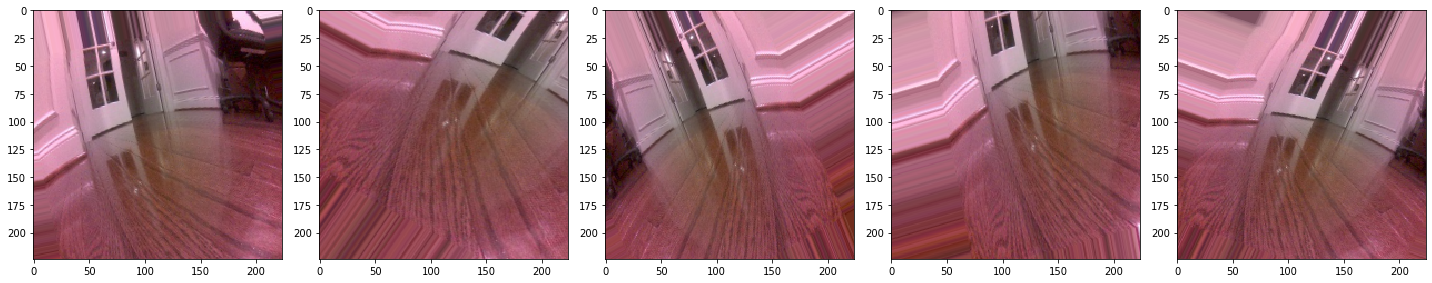

tf.Tensor([224 224   3], shape=(3,), dtype=int32)


In [27]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


# Creating Validation Data generator
Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [15]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 141 images belonging to 2 classes.


# **Model Creation**

Here we will define the model. 

# Simple Transfer Learning with TensorFlow Hub

We will use TensorFlow Hub to do Transfer Learning. Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

# Create a Feature Extractor
We will create a feature_extractor using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector.

Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) to see a list of available feature vectors. 

We will now create a feature_extractor by using *hub.KerasLayer* with the correct *input_shape* parameter.

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE, IMG_SHAPE,3))

# Freeze the Pre-Trained Model
In the cell below freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [0]:
feature_extractor.trainable = False


# Attach a classification head
Let us create a *tf.keras.Sequential* model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our training dataset. Finally print a summary of the Sequential model.

In [18]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Callbacks
Add callbacks to prevent overfitting and set the learning rate.

# *Early Stop*

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

# *Learning Rate Reduction*

We will reduce the learning rate when then accuracy not increase for 2 steps

In [19]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]



Using TensorFlow backend.


#Train the model
Train this model like any other, by first calling *compile* and then followed by *fit*.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:


EPOCHS = 22

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Train for 18 steps, validate for 5 steps
Epoch 1/22
18/18 [==============================] - 10s 570ms/step - loss: 0.6865 - accuracy: 0.6577 - val_loss: 0.5226 - val_accuracy: 0.7305
Epoch 2/22
18/18 [==============================] - 7s 363ms/step - loss: 0.5473 - accuracy: 0.7258 - val_loss: 0.3763 - val_accuracy: 0.8014
Epoch 3/22
18/18 [==============================] - 6s 359ms/step - loss: 0.4670 - accuracy: 0.7832 - val_loss: 0.3385 - val_accuracy: 0.8723
Epoch 4/22
18/18 [==============================] - 6s 359ms/step - loss: 0.4544 - accuracy: 0.7885 - val_loss: 0.3347 - val_accuracy: 0.8723
Epoch 5/22
18/18 [==============================] - 6s 358ms/step - loss: 0.4169 - accuracy: 0.7957 - val_loss: 0.3289 - val_accuracy: 0.8652
Epoch 6/22
18/18 [==============================] - 6s 354ms/step - loss: 0.4009 - accuracy: 0.8136 - val_loss: 0.3325 - val_accuracy: 0.8652
Epoch 7/22
18/18 [==============================] - 6s 359ms/step - loss: 0.4129 - accuracy: 0.8172 - val_

# Visualizing Results of the Training
We'll now visualize the results we get after training our network by plotting the training and validation graphs.

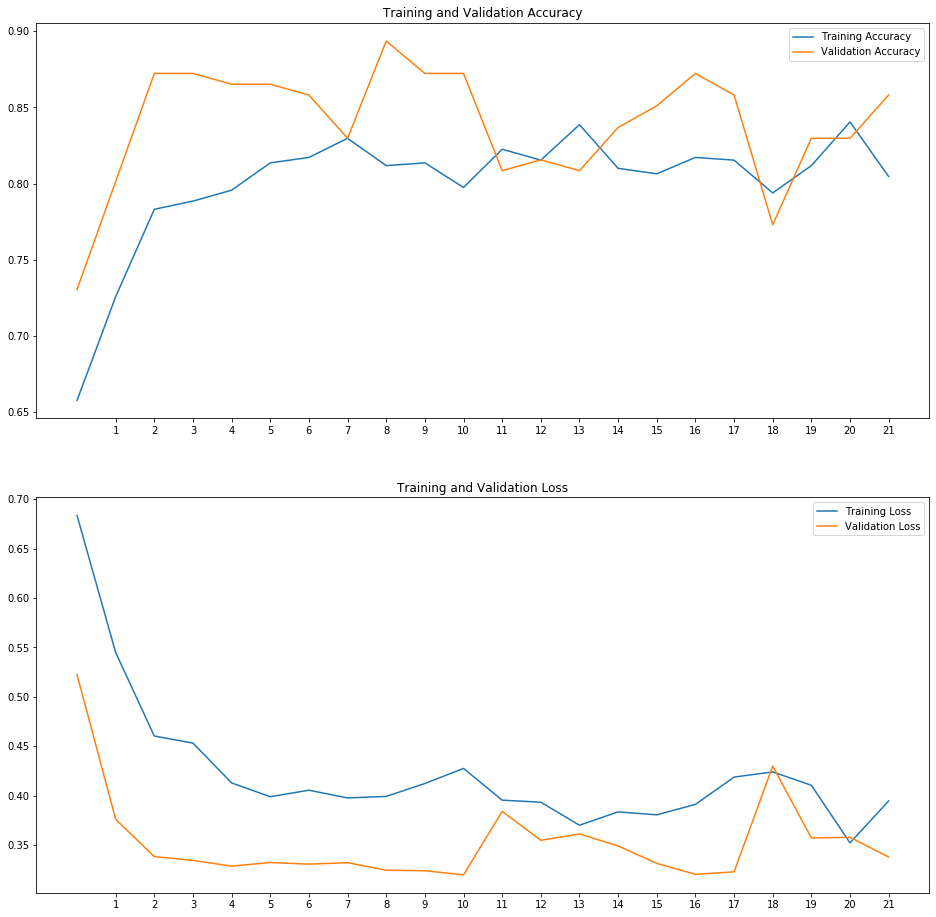

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)


plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.xticks(np.arange(1, EPOCHS, 1))

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xticks(np.arange(1, EPOCHS, 1))

plt.show()

# Save as Keras .h5 model
Now that we've trained the model, we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.

In [24]:
import time
t = time.time()

export_path_keras = "./collision_avoidance.{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./collision_avoidance.1577936737.h5
